In [27]:
from jorts_utils import *
DATA_PREFIX = './data'

In [28]:
import json
# loading Jorts' follower list
jorts_followers_time_bounded = json.load(
    open('{}/HASHED_jorts_follower_data_by_cursor_all.json'.format(DATA_PREFIX), 'r')
)
jorts_followers_ts = {}
for ts, followers_gained in jorts_followers_time_bounded.items():
    for f in followers_gained:
        jorts_followers_ts[f] = ts


In [30]:
# loading Jorts' account codings
jorts_ground_truth = json.load(open('{}/HASHED_jorts_ground_truth_full.json'.format(DATA_PREFIX), 'r'))
jorts_types_dict = {}
for k, v in jorts_ground_truth.items():
    jorts_types_dict[k] = int(v == 'Y')

In [31]:
import pandas as pd
rt_to_ts = json.load(open('{}/HASHED_jorts_rt_authors_to_ts.json'.format(DATA_PREFIX), 'r'))
prefix = '{}/jorts/'.format(DATA_PREFIX)

"""
These data structures map each followed account to a dict with the following structure:
{
    True: {
        ts1: estimated_jorts_followers_gained_on_ts1,
        ts2: estimated_jorts_followers_gained_on_ts2,
        ...
        ts14: estimated_jorts_followers_gained_on_ts14,
    },
    False: {
        ts1: estimated_non_jorts_followers_gained_on_ts1,
        ts2: estimated_non_jorts_followers_gained_on_ts2,
        ...
        ts14: estimated_non_jorts_followers_gained_on_ts14,
    },
}
For followers_gained_post_jorts, ts1 through ts14 are the days of the retweet until 14 days after it.
For followers_gained_pre_jorts, ts1 is 14 days before the retweet up until the day before the retweet.
"""

followers_gained_post_jorts = {}
followers_gained_pre_jorts = {}
rt_cursors = {} # keeps track of the relevant time bounds with respect to retweets

for rt_acct, rt_ts in rt_to_ts.items():
    
    followers_gained_post_jorts[rt_acct] = {}
    followers_gained_pre_jorts[rt_acct] = {}
    amplify_ts_dt = dt.datetime.strptime(rt_ts, '%Y%m%d') # time of amplification
    after_ts_dt = amplify_ts_dt + dt.timedelta(weeks=2) # 2 weeks later - cutoff
    before_ts_dt = amplify_ts_dt - dt.timedelta(weeks=2) # 2 weeks before - cutoff
    rt_cursors[rt_acct] = (
        dt_to_cursor(pd.to_datetime(amplify_ts_dt).tz_localize('utc')), 
        dt_to_cursor(pd.to_datetime(after_ts_dt).tz_localize('utc')),
    )
    followers_to_time_bounds = {}  

    try:
        follows_after = json.load(
            open(prefix + 'HASHED_{}_following_data_2_weeks_after_{}_all.json'.format(
                rt_acct, rt_ts
            ), 'r'
        ))
    except FileNotFoundError as e:
        print(e)
        continue
        
    follows_after_set, followers_to_time_bounds = parse_follower_info_and_begin_interpolation(
        follows_after,
        followers_to_time_bounds,
    )
            
    try:
        follows_on = json.load(
            open(prefix + 'HASHED_{}_following_data_post_{}_all.json'.format(
                rt_acct, rt_ts
            ), 'r'
        )) 
    except Exception as e:
        print(e)
        continue
    
    follows_on_set, followers_to_time_bounds = parse_follower_info_and_begin_interpolation(
        follows_on,
        followers_to_time_bounds,
    )
    
    follows_before = json.load(
        open(prefix + 'HASHED_{}_following_data_2_weeks_pre_{}_all.json'.format(
            rt_acct, rt_ts
        ), 'r'
    ))

    follows_before_set, followers_to_time_bounds = parse_follower_info_and_begin_interpolation(
        follows_before,
        followers_to_time_bounds,
    )
           
    accumulated_after =  follows_after_set - follows_on_set
    accumulated_before = follows_on_set - follows_before_set


    gained_after_followers, gained_after_non = interpolate_follower_non_follower_accumulation(
        accumulated_after, 
        amplify_ts_dt,
        after_ts_dt,
        followers_to_time_bounds,
        jorts_followers_ts,
        rt_cursors,
        rt_acct,
    )
    followers_gained_post_jorts[rt_acct][True] = gained_after_followers
    followers_gained_post_jorts[rt_acct][False] = gained_after_non
    
    gained_before_followers, gained_before_non = interpolate_follower_non_follower_accumulation(
        accumulated_before, 
        before_ts_dt,
        amplify_ts_dt,
        followers_to_time_bounds,
        jorts_followers_ts,
        rt_cursors,
        rt_acct
    )
    followers_gained_pre_jorts[rt_acct] = {}           
    followers_gained_pre_jorts[rt_acct][True] = gained_before_followers
    followers_gained_pre_jorts[rt_acct][False] = gained_before_non


[Errno 2] No such file or directory: './data/jorts/HASHED_20d9e4cae225fb9b1c0774dd5c72f6e848b89594_following_data_2_weeks_after_20220115_all.json'
[Errno 2] No such file or directory: './data/jorts/HASHED_53b53a14d8d76abac1134a11853ece2a8b9efdad_following_data_2_weeks_after_20220301_all.json'
[Errno 2] No such file or directory: './data/jorts/HASHED_e9efd0343979c4c8a6028bd232189bfb5e3e0309_following_data_2_weeks_after_20220224_all.json'
[Errno 2] No such file or directory: './data/jorts/HASHED_2b9769fd1303dd095c1880420cfcb7ae769b1727_following_data_2_weeks_after_20220220_all.json'
[Errno 2] No such file or directory: './data/jorts/HASHED_f7766c1a6617cb542922b1570f49aec461235af2_following_data_2_weeks_after_20220209_all.json'
[Errno 2] No such file or directory: './data/jorts/HASHED_fed00522b7bb4fd15df5632173a0c7d1a67b654d_following_data_2_weeks_after_20220214_all.json'
[Errno 2] No such file or directory: './data/jorts/HASHED_3680d5ebbb74e32b9c78b18dcd331b1cc80dcdff_following_data_2_we

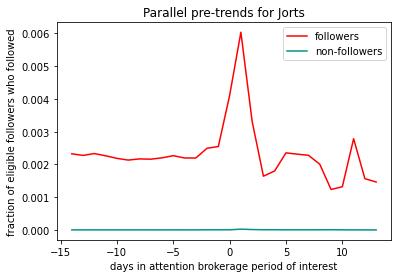

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
lvls_non = {i: [] for i in range(14)}
lvls_foll = {i: [] for i in range(14)}

line_non = []

line_foll = []

c = 0
# pre-trends analysis
for idx in range(14):
    for rt_acct, v in followers_gained_pre_jorts.items():
        if v == {}:
            lvls_foll[idx] = lvls_foll[idx] + [0]
            lvls_non[idx] = lvls_non[idx] + [0]
            continue
        lvls_foll[idx] = lvls_foll[idx] + [
            sorted([(k, vv) for k, vv in v[True].items()], key=lambda b: b[0])[idx][1] 
        ]
        lvls_non[idx] = lvls_non[idx] + [
            sorted([(k, vv) for k, vv in v[False].items()], key=lambda b: b[0])[idx][1] 
        ]
    mean_non = np.sum([i + c for i in np.array(lvls_non[idx]) / 10e8])
    mean_foll = np.sum([i + c for i in np.array(lvls_foll[idx]) / len(jorts_followers_ts)])
    line_non.append(mean_non)
    line_foll.append(mean_foll)

line_foll_b4 = line_foll
line_non_b4 = line_non

lvls_non = {i: [] for i in range(14)}
lvls_foll = {i: [] for i in range(14)}

line_non = []

line_foll = []
for idx in range(14):
    for rt_acct, v in followers_gained_post_jorts.items():
        if v == {}:
            lvls_foll[idx] = lvls_foll[idx] + [0]
            lvls_non[idx] = lvls_non[idx] + [0]
            continue
        lvls_foll[idx] = lvls_foll[idx] + [
            sorted([(k, vv) for k, vv in v[True].items()], key=lambda b: b[0])[idx][1] 
        ]
        lvls_non[idx] = lvls_non[idx] + [
            sorted([(k, vv) for k, vv in v[False].items()], key=lambda b: b[0])[idx][1] 
        ]
    mean_non = np.sum([i + c for i in np.array(lvls_non[idx]) / 10e8])
    mean_foll = np.sum([i + c for i in np.array(lvls_foll[idx]) / len(jorts_followers_ts)])
    
    line_non.append(mean_non)
    line_foll.append(mean_foll)
        
plt.plot(
    [i for i in range(-14, 14)], 
    list(line_foll_b4) + list(line_foll) , 
    color='red', 
    label='followers'
)
plt.plot(
    [i  for i in range(-14, 14)], 
    list(line_non_b4) + list(line_non) , 
    color='xkcd:teal', 
    label='non-followers'
)
plt.xlabel('days in attention brokerage period of interest')
plt.ylabel('fraction of eligible followers who followed')
plt.title('Parallel pre-trends for Jorts')
plt.legend()

In [33]:
import pandas as pd
import random
minimum_monday = pd.to_datetime(min([v for v in rt_to_ts.values()]), utc=True)

min_days = 10
max_brokerage = dt.datetime(year=2023, day=1, month=2, tzinfo=pytz.UTC)
vecs = []

# pre-RT gains for non-followers
for acct, gained in followers_gained_pre_jorts.items():
    if gained == {}:
        continue
    if acct == 'JortsTheCat':
        continue # ignore self-RTs
    gained = gained[False]
    acct_rt_ts = parse_cursor(rt_cursors[acct][0])
    # tried keeping track of time globally; this did not enhance the analysis.
    acct_type = 0
    for i, k in enumerate(sorted([k for k in gained.keys()])):
        vecs.append({
            'acct': acct, 
            'type': acct_type,
            'gain_rate': gained[k] / 10e8, 
            'period': int((acct_rt_ts - minimum_monday).days + (i - 14)) + 14, 
            'ts': i - 14,
            'treated': 0,
            'group': jorts_types_dict.get(acct, 0),
        })

# post-RT gains for non-followers
for acct, gained in followers_gained_post_jorts.items():
    if gained == {}:
        continue
    gained = gained[False]
    if acct == 'JortsTheCat':
        continue # ignore self-RTs
    acct_rt_ts = parse_cursor(rt_cursors[acct][0])
    acct_type = 0
    for i, k in enumerate(sorted([k for k in gained.keys()])):
        vecs.append({
            'acct': acct, 
            'type': acct_type,
            'gain_rate': gained[k] / 10e8, 
            'period': int((acct_rt_ts - minimum_monday).days + (i - 1)) + 14, 
            'ts': i - 1,
            'treated': 0,
            'group': jorts_types_dict.get(acct, 0),
        })

# followers' gains, pre-RT
for acct, gained in followers_gained_pre_jorts.items():
    if gained == {}:
        continue
    if acct == 'JortsTheCat':
        continue
    gained = gained[True]
    acct_rt_ts = parse_cursor(rt_cursors[acct][0])
    acct_type = 0
    for i, k in enumerate(sorted([k for k in gained.keys()])):
        vecs.append({
            'acct': acct, 
            'type': acct_type,
            'gain_rate': gained[k] / len(jorts_followers_ts), 
            'period': int((acct_rt_ts - minimum_monday).days + (i - 14)) + 14,
            'ts': i - 14,
            'treated': 0,
            'group': jorts_types_dict.get(acct, 0),
        })

# followers' gains, post-RT
for acct, gained in followers_gained_post_jorts.items():
    if gained == {}:
        continue
    gained = gained[True]
    if acct == 'JortsTheCat':
        continue
    acct_rt_ts = parse_cursor(rt_cursors[acct][0])
    acct_type = 0
    for i, k in enumerate(sorted([k for k in gained.keys()])):
        vecs.append({
            'acct': acct, 
            'type': acct_type,
            'gain_rate': gained[k] / len(jorts_followers_ts), 
            'period': int((acct_rt_ts - minimum_monday).days + (i - 1)) + 14,
            'ts': i - 1,
            'treated': 1,
            'group': jorts_types_dict.get(acct, 0),
        })


In [34]:
acct_nums = {}
acct_count = 0
# write to TSV for R
with open('{}/all_jorts_did_data_test_all.tsv'.format(DATA_PREFIX), 'w') as f:
    f.write('\t'.join(['id', 'X', 'G2', 'G', 'period', 'Y', 'treat', 'ts']))
    f.write('\n')
    for v in vecs:
        to_write = []
        if v['acct'] in acct_nums:
            to_write.append(str(acct_nums[v['acct']]))
        else:
            acct_nums[v['acct']] = acct_count
            acct_count += 1
            to_write.append(str(acct_nums[v['acct']]))
        # to_write.append(','.join([str(1) if k == v['type'] else str(0) for k in jorts_acct_types.keys()  ]))
        to_write.append(','.join(['0' for i in range(8)]))
        to_write.append(str(v['type']))
        to_write.append(str(v['group']))
        to_write.append(str(v['period']))
        to_write.append(str(v['gain_rate']))
        to_write.append(str(v['treated']))
        to_write.append(str(v['ts']))
        f.write('\t'.join(to_write) + '\n')